# The full detection chain for SM-SIF images

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.io import fits
import astroscrappy

In [3]:
from matplotlib.colors import LogNorm

In [4]:
import scipy.ndimage as ndimage

In [6]:
# order of CCD row and FOV in the following

row = [1,1,2,2,3,3,4,4,5,5,6,6,7,7]
fov = [1,2,1,2,1,2,1,2,1,2,1,2,1,2]

Files

In [9]:
# first light - this was before gaia even reached L2, so temperatures may be off
#sourcefile=("../../datasets/sif_fits/2014-01-03/SIF_PROCESSING_CCD_ROW_1_SM1_OBMT_START_5520130998393550_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2014-01-03/SIF_PROCESSING_CCD_ROW_7_SM1_OBMT_START_5520131000359150_CDP_NONE.fits")

# chury - outreach images of a comet. However, they don't cover all rows
#sourcefile=("../../datasets/sif_fits/2015-09-21/SIF_PROCESSING_CCD_ROW_1_SM2_OBMT_START_59854644999705500_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-09-21/SIF_PROCESSING_CCD_ROW_1_SM2_OBMT_START_59854611000722300_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-09-14/SIF_PROCESSING_CCD_ROW_3_SM2_OBMT_START_59249471998982300_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-09-21/SIF_PROCESSING_CCD_ROW_4_SM2_OBMT_START_59832995000716700_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-09-15/SIF_PROCESSING_CCD_ROW_5_SM1_OBMT_START_59286298999010300_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-09-14/SIF_PROCESSING_CCD_ROW_5_SM2_OBMT_START_59271081999976700_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-09-21/SIF_PROCESSING_CCD_ROW_6_SM1_OBMT_START_59804985000225500_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-09-15/SIF_PROCESSING_CCD_ROW_7_SM1_OBMT_START_59307910000495100_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-09-15/SIF_PROCESSING_CCD_ROW_7_SM1_OBMT_START_59307943999478300_CDP_NONE.fits")

# CTI measurements from SM
ctifiles = [
"CI_IN_SM_2016-05-20_CCD_ROW_1_SM1_OBMT_START_80711440999891100_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_1_SM2_OBMT_START_80711440999891100_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_2_SM1_OBMT_START_80712641000656700_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_2_SM2_OBMT_START_80712641000656700_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_3_SM1_OBMT_START_80713835998970300_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_3_SM2_OBMT_START_80713835998970300_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_4_SM1_OBMT_START_80715038000716700_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_4_SM2_OBMT_START_80715038000716700_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_5_SM1_OBMT_START_80716237999516700_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_5_SM2_OBMT_START_80716237999516700_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_6_SM1_OBMT_START_80717438000282300_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_6_SM2_OBMT_START_80717438000282300_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_7_SM1_OBMT_START_80718637999082300_CDP_NONE.fits",
"CI_IN_SM_2016-05-20_CCD_ROW_7_SM2_OBMT_START_80718637999082300_CDP_NONE.fits"
]

Gains

In [10]:
# in the same order as above, in units of e-/ADU
# this is from Cian's E-Mail

gains = [
3.85356454721,
4.02576489533,
3.94321766562,
3.93081761006,
3.69822485207,
4.02900886382,
4.00480576692,
3.86249517188,
3.98089171975,
3.95413206801,
3.83877159309,
3.61794500724,
3.84467512495,
3.89711613406
]

Determine readnoise and bias

In [11]:
def sm_readnoise_bias(file, gain):
    """
    Extract the readnoise in e- and bias in ADU from the CTI measurement file.
    The bias includes the prescan column.
    """
    import numpy as np
    from astropy.io.fits import getdata
    from scipy.stats import trim1

    
    darkframe = getdata(file)[1500:4500,:]   # this is roughly the region where gate 1 is set
    
    # the bias
    bias = np.median(darkframe, axis=0)
    
    # the readnoise, from the prescan column
    # bias must be subtracted, then
    # throw away far outliers, in case of cosmics
    prescan = darkframe[:,:7]
    prescan = np.subtract(prescan, bias[:7])
    rnoise = np.std(trim1(prescan,0.01,"right"))   
    
    return gain*rnoise, bias

In [12]:
noises = np.empty(len(row))
biases = []

In [13]:
for ii in range(len(row)):
    (noises[ii], bias) = sm_readnoise_bias(ctifiles[ii],gains[ii])
    biases.append(bias)

In [14]:
biases = np.array(biases)

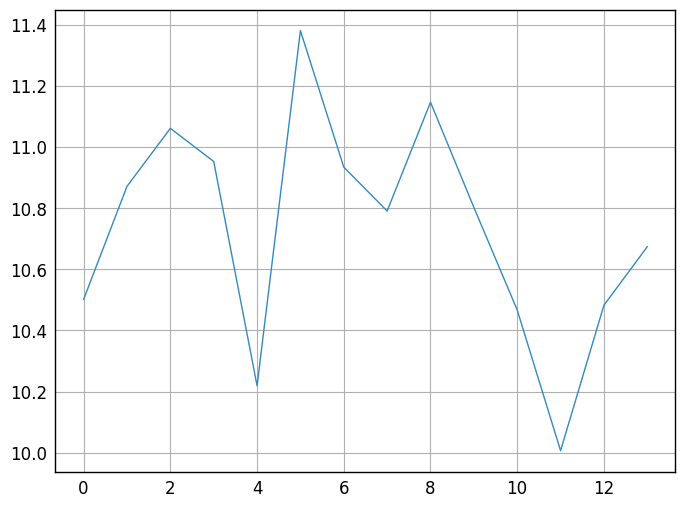

In [15]:
plt.plot(noises)

Write everything into a simple fits file

In [16]:
nrows = len(row)

colrow = fits.Column(name="CCD_ROW", array=row, format="I")
colfov = fits.Column(name="FOV", array=fov, format="I")

colbias = fits.Column(name="BIAS", array=biases, format=str(biases.shape[1])+"I",
                      unit="ADU")
colgain = fits.Column(name="GAIN", array=gains, format="E", unit="e-/ADU")
colrnoise = fits.Column(name="RNOISE",array=noises, format="E", unit="e-")


In [17]:
t = fits.BinTableHDU.from_columns([colrow,colfov,colbias,colgain,colrnoise])
t.name="DATA"

t.header.comments["TTYPE1"] = "CCD ROW"
t.header.comments["TTYPE2"] = "Field of View"
t.header.comments["TTYPE3"] = "AC dependent bias [ADU]"
t.header.comments["TTYPE4"] = "CCD gain [e-/ADU]"
t.header.comments["TTYPE5"] = "CCD readnoise [e-]"

In [18]:
t.writeto("sm_calibdat.fits",overwrite=True)